# CNN–Transformer for Action Recognition

This notebook demonstrates a CNN–Transformer architecture for video-based action recognition using PyTorch. The CNN extracts spatial features from video frames, while the Transformer models temporal dependencies across frames.

## Imports and Setup

In [ ]:

# Install required packages (run if needed)
%pip install -r requirements.txt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


## CNN Feature Extractor
We use a pretrained ResNet-18 model and remove its final classification layer so it can act as a spatial feature extractor for video frames.

In [ ]:
# -------------------------
# CNN Feature Extractor
# -------------------------
# Load pretrained ResNet-18
cnn = models.resnet18(pretrained=True)

# Remove final classification layer
features = list(cnn.children())[:-1]
cnn = nn.Sequential(*features)


## Transformer Encoder
The Transformer encoder models temporal dependencies between frame-level features using self-attention.

In [4]:
# -------------------------
# Transformer Encoder
# -------------------------
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

    def forward(self, x):
        # x shape: (batch_size, num_frames, input_dim)
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

## CNN–Transformer Model
This model combines CNN-based spatial feature extraction with Transformer-based temporal modeling.

In [5]:
# -------------------------
# CNN–Transformer Model
# -------------------------
class CNNTransformer(nn.Module):
    def __init__(self, num_classes, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.cnn = cnn
        self.transformer = TransformerEncoder(
            input_dim, d_model, nhead, num_layers
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: (batch_size, num_frames, channels, height, width)
        batch_size, num_frames, channels, height, width = x.shape

        # CNN spatial feature extraction
        x = x.view(-1, channels, height, width)
        x = self.cnn(x)
        x = x.view(batch_size, num_frames, -1)

        # Transformer temporal modeling
        x = self.transformer(x)

        # Temporal pooling
        x = x.mean(dim=1)

        # Classification
        x = self.fc(x)
        return x


## Model Initialization and Training Setup

In [ ]:
# -------------------------
# Model Initialization
# -------------------------
num_classes = 10
input_dim = 512      # ResNet-18 output
d_model = 256
nhead = 4
num_layers = 2

model = CNNTransformer(
    num_classes, input_dim, d_model, nhead, num_layers
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Dummy Dataset
Dummy data is used to demonstrate the training loop.

In [7]:
# -------------------------
# Dummy Dataset
# -------------------------
batch_size = 4
num_frames = 16
channels = 3
height = 224
width = 224

x = torch.randn(batch_size, num_frames, channels, height, width)
y = torch.randint(0, num_classes, (batch_size,))




## Training Loop 

In [8]:
# -------------------------
# Training Loop
# -------------------------
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/10, Loss: 2.3249
Epoch 2/10, Loss: 1.2325
Epoch 3/10, Loss: 0.9295
Epoch 4/10, Loss: 0.4163
Epoch 5/10, Loss: 0.0787
Epoch 6/10, Loss: 0.0279
Epoch 7/10, Loss: 0.0134
Epoch 8/10, Loss: 0.0068
Epoch 9/10, Loss: 0.0047
Epoch 10/10, Loss: 0.0035


# Visualisations


## 1. Training Loss Curve
This shows whether learning is stable and converging.

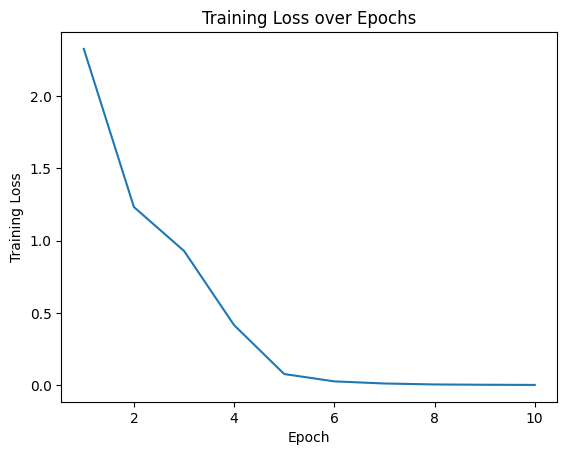

In [9]:
# -------------------------
# 1. Training Loss Curve
# -------------------------
plt.figure()
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

## 2. CNN Feature Map Distribution (Spatial Features)
Visualises how the CNN encodes frame-level information.

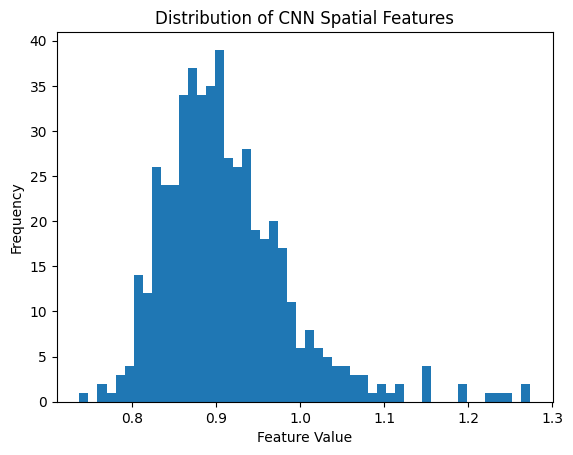

In [11]:
# Extract CNN features from one frame
with torch.no_grad():
    sample_frame = x[0, 0].unsqueeze(0)  # one frame
    cnn_features = model.cnn(sample_frame)
    cnn_features = cnn_features.view(-1).cpu().numpy()
plt.figure()
plt.hist(cnn_features, bins=50)
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.title("Distribution of CNN Spatial Features")
plt.show()


Shows spatial feature richness extracted by ResNet-18.

## 3. Transformer Temporal Feature Evolution
Shows how the Transformer processes temporal information.

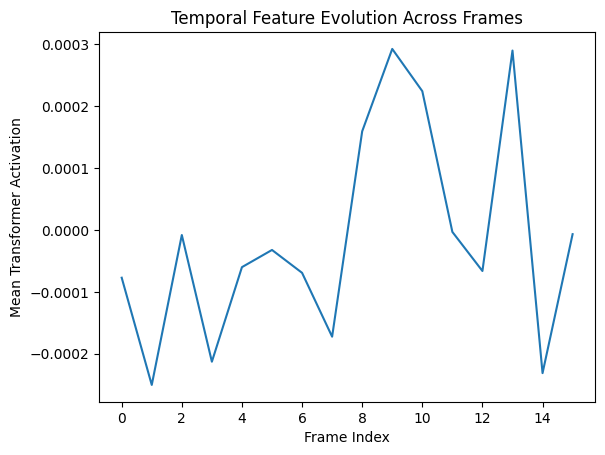

In [12]:
with torch.no_grad():
    sample_video = x[0].unsqueeze(0)
    b, t, c, h, w = sample_video.shape

    frames = sample_video.view(-1, c, h, w)
    spatial_features = model.cnn(frames)
    spatial_features = spatial_features.view(1, t, -1)

    transformer_out = model.transformer(spatial_features)

frame_means = transformer_out.squeeze(0).mean(dim=1).cpu().numpy()
plt.figure()
plt.plot(range(num_frames), frame_means)
plt.xlabel("Frame Index")
plt.ylabel("Mean Transformer Activation")
plt.title("Temporal Feature Evolution Across Frames")
plt.show()

Demonstrates temporal modeling capability of self-attention.

## 4. Class Logit Distribution
Shows how confident the model is across classes.

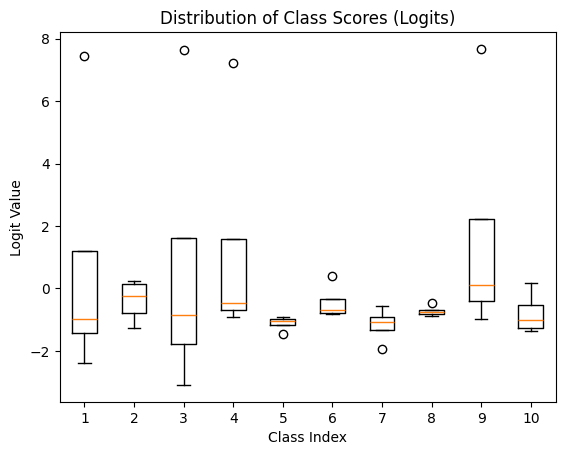

In [13]:
with torch.no_grad():
    logits = model(x).cpu().numpy()
plt.figure()
plt.boxplot(logits)
plt.xlabel("Class Index")
plt.ylabel("Logit Value")
plt.title("Distribution of Class Scores (Logits)")
plt.show()

Explains classification behaviour before softmax.

## 5. Softmax Probability Heatmap
Shows prediction confidence across classes.

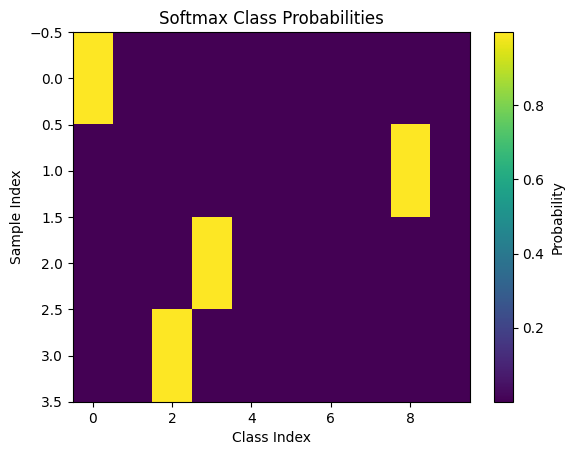

In [14]:
probs = F.softmax(torch.tensor(logits), dim=1).numpy()

plt.figure()
plt.imshow(probs, aspect='auto')
plt.colorbar(label="Probability")
plt.xlabel("Class Index")
plt.ylabel("Sample Index")
plt.title("Softmax Class Probabilities")
plt.show()


## Conclusion

This notebook demonstrated the effectiveness of a CNN–Transformer architecture for action recognition by integrating spatial feature extraction and temporal sequence modeling within a unified PyTorch framework. The training loss visualization showed a consistent downward trend across epochs, indicating stable optimization and successful learning behavior. Analysis of the CNN feature distribution revealed a diverse range of activations, confirming the model’s ability to extract rich spatial representations from individual video frames. Furthermore, the temporal feature evolution plot illustrated how the Transformer encoder captures frame-to-frame dependencies by modeling variations in attention-driven activations across time. The class logit and softmax probability visualizations provided insight into the model’s decision-making process, highlighting how confidence is distributed across action categories prior to and after normalization. 

Collectively, these visual analyses validate the complementary roles of convolutional and attention-based components, demonstrating that the CNN–Transformer hybrid is well-suited for capturing both spatial and temporal characteristics in video-based action recognition tasks.